# Data-compatibility frequency heatmap for the HGT 2 strains simulation

## Creating the different heatmaps for the figure ... with s drawn from  gamma laws of varying shape

Please note that this script needs to be in the same folder as the folder "/Simuls" with all the simulations in it, that can be downloaded with this script 

You can also use it to draw the heatmaps from data you would have independantly simulated with the "2strains_4_colors_gamma.py" code 

Please note that in this case you will have to change some of the script in the cell before the last one (image creation), as explained in the cell

In [1]:
%matplotlib inline

import os
import csv
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import colors
from scipy.stats import fisher_exact

In [2]:
# Set parameters and manage paths and folders

# Path to your current working directory and to where the data is stored
path = os.getcwd()
folder = "/Simuls"  # path to where the simulated data is stored


# output directory for the heatmap
output_dir = path + "/Heatmaps"
if not os.path.exists(output_dir) :
    os.mkdir(output_dir)  # create the output directory "Heatmaps" if it doesn't exist yet

s_list = [round(10**(exp_s/10-4), 5) for exp_s in range(0,31)]  # mean selective effect, from 10^(-4) to 10^(-1) with logarithmic scale
s_list.reverse()  # with plt.imshow or plt.pcolor the [0,0] case is in the top left corner, so I have to reverse the y axis to put the smallest s value in the bottom left corner

u_list = [round(10**(exp_u/10-8), 9) for exp_u in range(0,10)] + [round(10**(exp_u/10-7), 8) for exp_u in range(0,31)] # from 10^(-8) to 10^(-4) with logarithmic scale

k_list=[100,10,1]

p=0.1  # initial frequency of invading strain

N_tot = 1e6 # total population simulated
# I set it to a concise format for printing
formatted_num = "{:.0e}".format(N_tot)
mantissa, exponent = formatted_num.split("e")
N_to_print = "{}e{}".format(mantissa, int(exponent))



rep = 10  # number of replicates 


# Name of the colormap for the heatmaps
cm_name = 'Reds'





In [3]:
# Compute Fisher exact test value

min_non_significant = rep
# Create a 2x2 contingency table
for i in range(rep+1) :
    contingency_table = [[i, 8], [rep-i, 0]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    if p_value > 0.05 :
        min_non_significant = i
        break

min_sign_freq = i/rep  # minimal non-significative frequency
print(min_sign_freq)

0.6


In [4]:
## Create the images as np arrays for the different gamma shapes ; takes around 3 minutes to run on my computer
# be careful the data I use for this figure is the data provided with this code, and for some of them (k=1 and k=100),
# it coutains only the size of each strain at the last generation and not accros all generations, so the name of the files are a bit different.
# However if you simulate these data with the code "2strains_4_colors_gamma.py" given with this script, the output files will countain the 
# population sizes for every generation as in the k=10 files. 
# So if you want to use data simulated by the simulation code you have to comment the if/else condition and only keep the code that is
# in the "if k==10 :" condition, correctly indented.

# Number of s and u values
s_l = len(s_list)
u_l = len(u_list)

# create the 3 heatmaps as images of s_l x u_l pixels, all set to 0 for the moment
image_list = [np.zeros((s_l,u_l)), np.zeros((s_l,u_l)) , np.zeros((s_l,u_l)) ]

for i_k, k in enumerate(k_list) :
    for i,s in enumerate(s_list) : # for all selective advantage values
        for j,u in enumerate(u_list) : # for all mutation rate values
            n_comp = 0 # number of data-compatible replicates
            for r in range(1, rep+1) : # for each replicate

                if k==10 :
                    name =  "/Multi_Gamma_u"+str(u)+"_s"+str(s)+"_k"+str(k)+"_Ntot"+N_to_print+"_p"+str(p)
                    glob_dir = path+folder+name # path to the folder with the data
                    file = glob_dir  +  name+"_rep"+str(r)  +   name+"_rep"+str(r)+"_Numbers.csv"  # name of the "numbers" file
                    with open(file, 'r', newline="") as csv_file : # open it
                        csv_reader = csv.reader(csv_file)
                        rows = list(csv_reader)
                        last_row = [int(car) for car in rows[-1]] # only take the last row
                        if last_row[0]==1600 and last_row[3]>0 and last_row[4]>0 and ((last_row[1]==0 and last_row[2] > 0) or (last_row[2]==0 and last_row[1] > 0)) : 
                            # the simulation ran till the end, and the two resident strain are still alive, and one of the invading strain is dead, the other is stilla live
                            n_comp +=1 # one more replicate is compatible with the data

                else : # k=1 or 100
                    if k==100 :
                        name =  "/Multi_Gamma_u"+str(u)+"_s"+str(s)+"_k"+str(k)+"_Ntot"+N_to_print+"_p"+str(p)  # name of the folder with the data
                    else : # k=1
                        name = "/Multi_Gamma_u"+str(u)+"_s"+str(s)+"_Ntot"+N_to_print+"_p"+str(p)  # no k=1 in the title of this one for historical reasons

                    glob_dir = path+folder+name 
                    file = glob_dir  +  name+"_rep"+str(r)+".csv"

                    with open(file, 'r', newline="") as csv_file : # open it
                        csv_reader = csv.reader(csv_file)
                        rows = list(csv_reader)
                        last_row = [int(car) for car in rows[-1][5:10]] # the file has only two rows to sum up informations
                        
                        if last_row[0]==1600 and last_row[3]>0 and last_row[4]>0 and ((last_row[1]==0 and last_row[2] > 0) or (last_row[2]==0 and last_row[1] > 0)) : 
                            # the simulation ran till the end, and the two resident strain are still alive, and one of the invading strain is dead, the other is stilla live
                            n_comp +=1 # one more replicate is compatible with the data



            image_list[i_k][i,j] = n_comp/rep  # set the pixel in position i,j to the proportion of data-compatible replicates

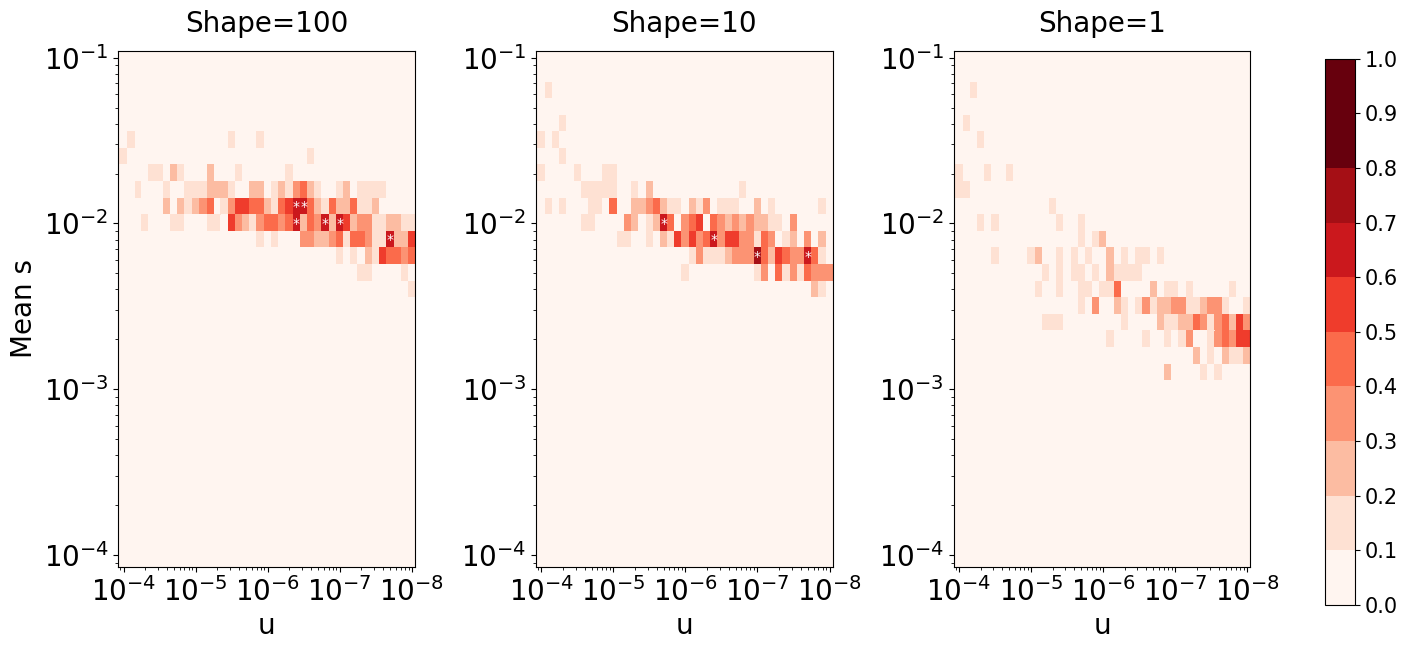

In [5]:

fig,ax = plt.subplots(1,3,figsize=(15,7))


X,Y=np.meshgrid(u_list,s_list)
 
# edit colormap
cmap = plt.get_cmap(cm_name)
n_levels = rep
bounds = np.linspace(0, 1, n_levels)
norm = colors.BoundaryNorm(bounds, cmap.N)
cmap = colors.ListedColormap(cmap(norm(bounds)))

font='sans-serif'
fontsize=20

# add k=100
for i_k,k in enumerate(k_list) :
    mappable=ax[i_k].pcolor(X,Y,image_list[i_k], cmap=cmap, vmin=0, vmax=1)
    ax[i_k].set_title(f"Shape={k}", fontsize=fontsize, family=font, y=1.02)
    ax[i_k].set_xscale('log')
    ax[i_k].set_yscale('log')
    ax[i_k].set_xlabel("u", fontsize=fontsize, family=font)
    ax[i_k].set_xticks([10**(-i) for i in range(4,9)], family=font, fontsize=fontsize, labels=["$10^{-8}$","$10^{-7}$","$10^{-6}$","$10^{-5}$","$10^{-4}$"])

    ax[i_k].set_yticks([10**(-i) for i in range(1,5)], family=font, fontsize=fontsize, labels=["$10^{-1}$","$10^{-2}$","$10^{-3}$","$10^{-4}$"])

    # Add white asterisk to the corresponding significant points
    indices = np.where(image_list[i_k] >= min_sign_freq)  # i,j values where the hypothesis that experimental data and simulated data are compatible cannot be rejected with <5% error estimation
    if indices[0].size > 0 and indices[1].size > 0:
        for i,j in zip(indices[1],indices[0]) :
            ax[i_k].text(u_list[i], s_list[j], '*', fontsize=10, ha='center', va='center', color='white')

ax[0].set_ylabel("Mean s", fontsize=fontsize, family=font)
fig.tight_layout(pad=2.5)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.78])
cbar=fig.colorbar(mappable=mappable, cax=cbar_ax, orientation='vertical', ticks=np.linspace(0, 1, n_levels+1))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)


figname = output_dir + "/HeatmapsWT4colorsPaperFigSup__big_letters.png"
# plt.savefig(figname, dpi=300)

